# Home Work 4. Алгоритм построения дерева решений

Для выполнения домашнего задания будем использовать файл Lesson_4_extended.ipynb (из материалов к уроку):

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D 
from sklearn import datasets
from sklearn import model_selection

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)

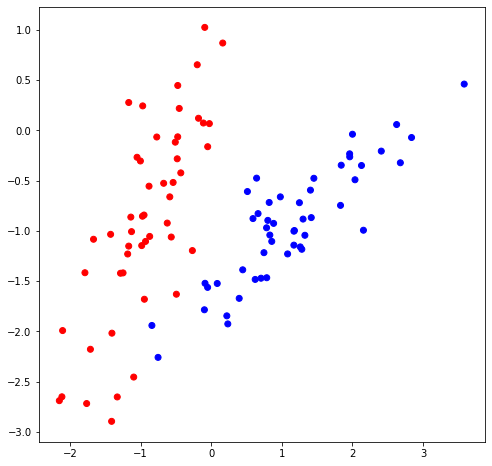

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$


In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

$$H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$


In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

# ИЗМЕНЕНИЯ
def find_best_split(data, labels, stop_rule, deep):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
        
            # ИЗМЕНЕНИЯ
            if stop_rule:
                if (stop_rule( \
                    deep=deep, \
                    current_gain=current_gain, \
                    best_gain=best_gain, \
                    true_labels=true_labels, \
                    false_labels=false_labels) \
                ):
                    continue
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

# ИЗМЕНЕНИЯ
def build_tree(data, labels, stop_rule=None, _deep=1):

    # ИЗМЕНЕНИЯ
    gain, t, index = find_best_split(data, labels, stop_rule=stop_rule, deep=_deep)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    # ИЗМЕНЕНИЯ
    true_branch = build_tree(true_data, true_labels, stop_rule=stop_rule, _deep=_deep+1)
    # ИЗМЕНЕНИЯ
    false_branch = build_tree(false_data, false_labels, stop_rule=stop_rule, _deep=_deep+1)
    
#     print(time.time(), false_branch)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [14]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [15]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


# ИЗМЕНЕНИЯ
def visualize(train_data, train_labels, test_data, test_labels, tree):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()
    


### Задача 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [16]:
# Реализуем различные критерии остановки обучения дерева

# Проверка на максимальную глубину дерева
max_deep_criterion = lambda deep: lambda **kwargs: kwargs["deep"] > deep

# Проверка на минимальное приращеине критерия качества 
min_gain_diff_criterion = lambda min_gain: lambda **kwargs: kwargs["current_gain"] - kwargs["best_gain"] < min_gain

# Вспомогательная функция для определения идентичности всех элементов массива
is_same_labels = lambda labels: np.unique(labels).size == 1

# Проверка что все значения в узле принадлежат одному классу
same_classes_at_leaf_criterion = lambda **kwargs: is_same_labels(kwargs["true_labels"]) - is_same_labels(kwargs["false_labels"])

# Проверка на минимальное число элементов выборки в узле
min_obj_at_leaf_criterion = lambda min_leaf: lambda **kwargs: len(kwargs["true_labels"]) < min_leaf and len(kwargs["false_labels"]) < min_leaf

In [17]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, 
    classification_labels,
    test_size = 0.3,
    random_state = 5
)

In [18]:
# Метод для получения информации о дереве: глубина, количество листьев и количество узлов

def get_info(node):
    if isinstance(node, Leaf):
        return 0, 1, 0

    l_deep, l_leafs, l_nodes =  get_info(node.true_branch)    
    r_deep, r_leafs, r_nodes =  get_info(node.false_branch)

    deep = max(l_deep, r_deep) + 1
    leafs = l_leafs + r_leafs
    nodes = l_nodes + r_nodes + 1

    return deep, leafs, nodes


Критерий остановки: нет критерия
Глубина: 	3
Узлов: 		3
Листьев: 	4
Точность обучающей выборки: 	100.0
Точность тестовой выборки: 	86.66666666666667


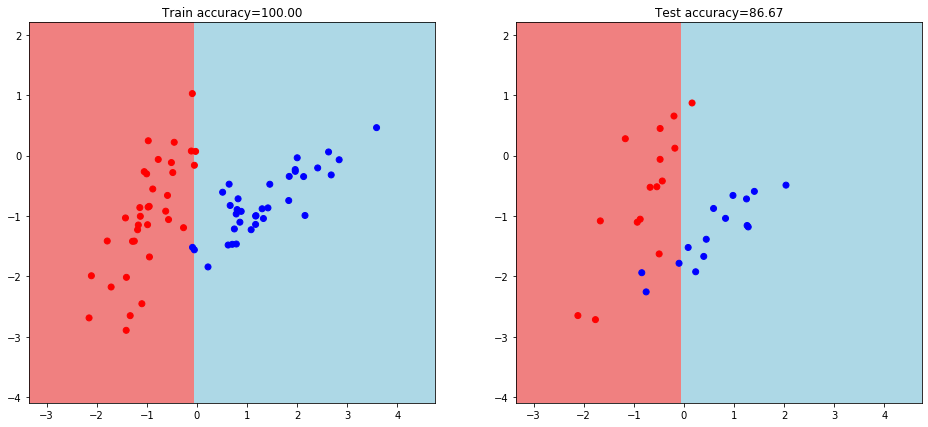


Критерий остановки: глубина дерева больше 3
Глубина: 	3
Узлов: 		3
Листьев: 	4
Точность обучающей выборки: 	100.0
Точность тестовой выборки: 	86.66666666666667


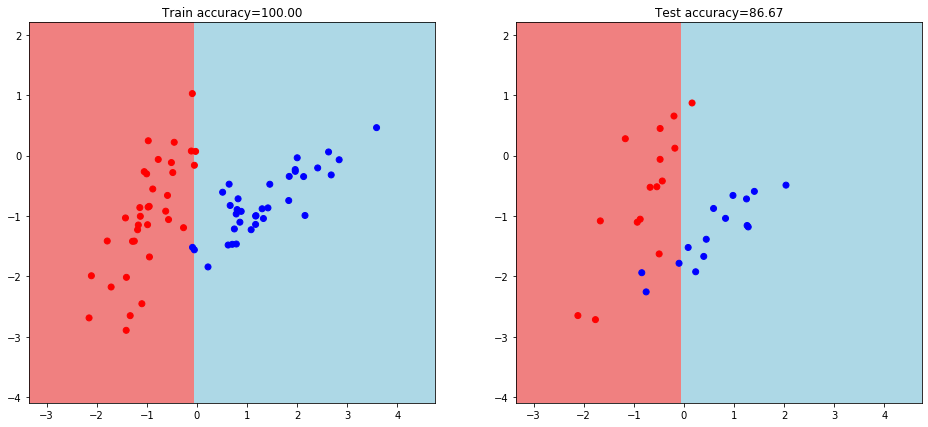


Критерий остановки: приращение функционала качества меньше 0.01
Глубина: 	3
Узлов: 		3
Листьев: 	4
Точность обучающей выборки: 	100.0
Точность тестовой выборки: 	86.66666666666667


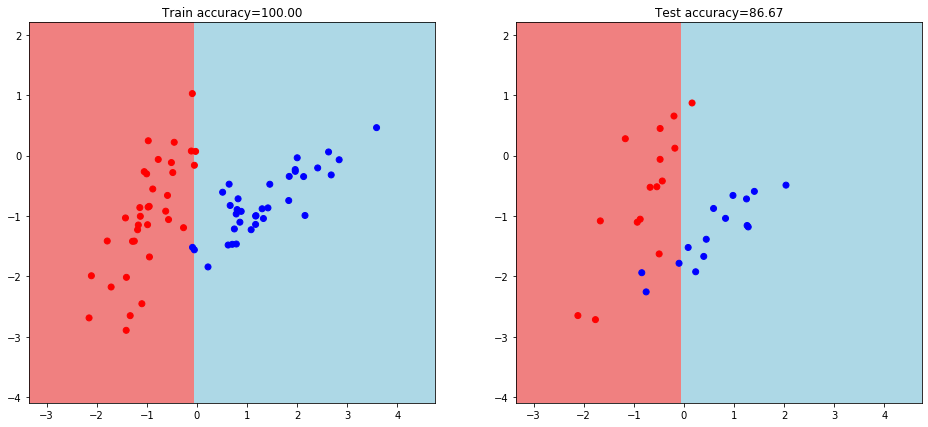


Критерий остановки: в листе все элементы одного класса
Глубина: 	3
Узлов: 		5
Листьев: 	6
Точность обучающей выборки: 	100.0
Точность тестовой выборки: 	86.66666666666667


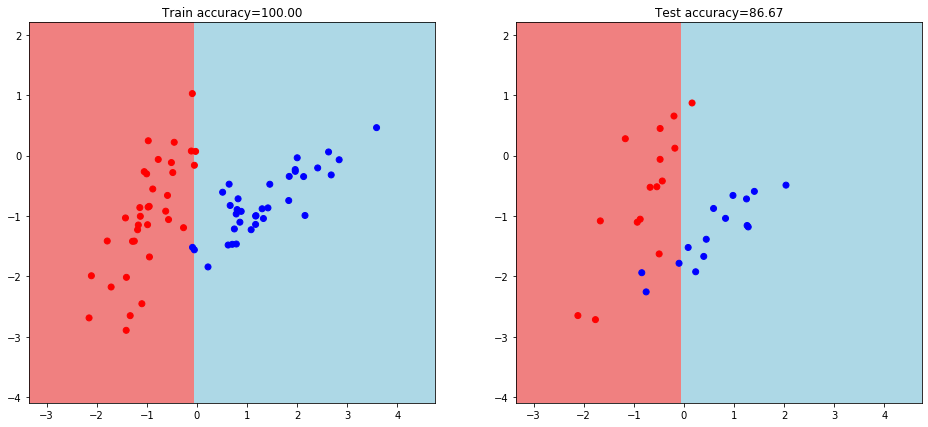


Критерий остановки: минимум 5 элементов в листе
Глубина: 	2
Узлов: 		2
Листьев: 	3
Точность обучающей выборки: 	97.14285714285714
Точность тестовой выборки: 	86.66666666666667


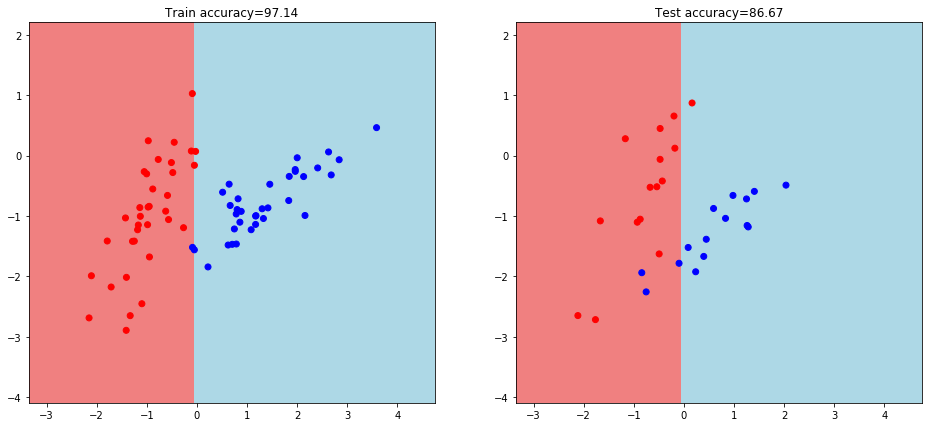

In [19]:
# Критерии остановки
criterions = [
    (None, 'нет критерия'),
    (max_deep_criterion(3), 'глубина дерева больше 3'),
    (min_gain_diff_criterion(0.01), 'приращение функционала качества меньше 0.01'),
    (same_classes_at_leaf_criterion, 'в листе все элементы одного класса'),
    (min_obj_at_leaf_criterion(5), 'минимум 5 элементов в листе'),
]

for stop_rule, criterion_label in criterions:
    print(f'\nКритерий остановки: {criterion_label}')

    # обучение
    my_tree = build_tree(train_data, train_labels, stop_rule=stop_rule)

    # размеры дерева
    deep, leafs, nodes = get_info(my_tree)
    print(f'Глубина: \t{deep}\nУзлов: \t\t{nodes}\nЛистьев: \t{leafs}')

    # предсказание
    train_answers = predict(train_data, my_tree)
    test_answers = predict(test_data, my_tree)

    # параметры точности
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность обучающей выборки: \t{train_accuracy}\nТочность тестовой выборки: \t{test_accuracy}')

    visualize(train_data, train_labels, test_data, test_labels, my_tree)

### Задача 2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [20]:
# Сгенерируем набор данных

regression_data, regression_labels, coef = datasets.make_regression(
    n_samples=10000, 
    n_features = 2, 
    n_informative = 2, 
    n_targets = 1,
    noise = 5,
    coef = True,
    random_state = 5
)

<Figure size 1080x1080 with 0 Axes>

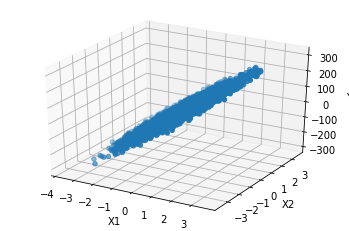

In [21]:
# Визуализация исходного набора данных

plt.figure(figsize = (15, 15))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(regression_data[:,0], regression_data[:,1], regression_labels)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

plt.show();

Переопределим класс узла, критерий Джини и метрику точности для модели регрессии.

In [22]:
# Класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction

In [23]:
# Расчет критерия информативности
def gini(labels):
    return np.inf if len(labels) == 0 else np.var(labels, ddof=1)

# Метрика точности mse
def accuracy_metric(actual, predicted): 
    return np.mean((actual - predicted) ** 2)

In [24]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    regression_data, 
    regression_labels,
    test_size = 0.3,
    random_state = 5
)

In [25]:
# обучение
my_tree = build_tree(train_data, train_labels, stop_rule=min_gain_diff_criterion(1))

# размеры дерева
deep, leafs, nodes = get_info(my_tree)
print(f'Глубина: \t{deep}\nУзлов: \t\t{nodes}\nЛистьев: \t{leafs}')

# предсказание
train_answers = predict(train_data, my_tree)
test_answers = predict(test_data, my_tree)

# параметры точности
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'MSE обучающей выборки: \t{train_accuracy}\nMSE тестовой выборки: \t{test_accuracy}')

Глубина: 	19
Узлов: 		2094
Листьев: 	2095
MSE обучающей выборки: 	9.045055805753089
MSE тестовой выборки: 	47.23578279536266


In [26]:
np.array([train_labels, train_answers]).T[0:10]

array([[ 44.43260232,  43.48791973],
       [103.41440478, 102.52086573],
       [  5.0945074 ,   2.45751279],
       [ 26.7555979 ,  27.56645166],
       [122.49493139, 131.77615096],
       [ 67.21671674,  62.40219653],
       [-76.44497538, -79.22772733],
       [ 58.83209048,  56.69141489],
       [148.06499438, 146.99920279],
       [-52.92998506, -59.42706759]])

In [27]:
np.array([test_labels, test_answers]).T[0:10]

array([[  66.34920058,   58.06776664],
       [ 103.20201165,  103.51044164],
       [ 158.62581287,  154.75777365],
       [  47.71014067,   46.89743337],
       [  18.50501097,    9.43313091],
       [-103.52044303, -109.5553257 ],
       [  28.6780577 ,   29.84435145],
       [ 101.4972668 ,  110.37846784],
       [-177.16884031, -164.73476661],
       [  -2.92586261,   -8.37681763]])